In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import nmrglue as ng
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 100000

# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = "MLP-Exp_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/ModelPerformanceMetrics') #Save random seed used
seed = 4
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [2]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra = np.load('ExperimentalLikeDataset_Spec.npy')
conc1 = np.load('ExperimentalLikeDataset_Conc.npy')

# Load validation dataset
spectraVal = np.load('ExperimentalLikeDataset_ValSpec.npy')
concVal = np.load('ExperimentalLikeDataset_ValConc.npy')

# Load representative validation spectra
ValSpectra = np.load("ExperimentalLikeDatasetRepresentativeExamples_Spectra.npy")
ValConc = np.load("ExperimentalLikeDatasetRepresentativeExamples_Concentrations.npy")
ValSpecNames = np.load("ExperimentalLikeDatasetRepresentativeExamples_VariableNames.npy")

In [3]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [4]:
## Set up data for testing and training

# Split into testing and training data
X_train1, X_test1, y_train1, y_test1 = train_test_split(spectra, conc1, test_size = 0.2, random_state = 0)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train1).float()
y_train = torch.tensor(y_train1).float()
X_test = torch.tensor(X_test1).float()
y_test = torch.tensor(y_test1).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
spectraVal = torch.tensor(spectraVal).float().to(device)   # Confusing names, these spectra are the 5000 spectra generated like the training dataset
ValSpectra = torch.tensor(ValSpectra).float().to(device)   # Confusing names, these spectra are the 10 representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
concVal = torch.tensor(concVal).float().to(device)
ValConc = torch.tensor(ValConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 128, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 128, shuffle=True)

In [5]:
## Define NN model object, define some parameters, and instantiate model

# Define some model & training parameters
size_hidden1 = 200
size_hidden2 = 8
criterion = nn.MSELoss(reduction='sum')


# Define model
class NMR_Model_Aq(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(39500, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
    def forward(self, input):
        return (self.lin2(self.relu1(self.lin1(input))))

In [ ]:
## Define NN model object, define some parameters, and instantiate model

# Define some model & training parameters
size_hidden1 = 200
size_hidden2 = 200
size_hidden3 = 8
criterion = nn.MSELoss(reduction='sum')

# Define model
class NMR_Model_Aq(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(39500, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()  
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        
    def forward(self, input):
        x = self.relu1(self.lin1(input))
        x = self.relu2(self.lin2(x))
        return self.lin3(x)

In [275]:
## Define NN model object, define some parameters, and instantiate model

# Define some model & training parameters
size_hidden1 = 200
size_hidden2 = 200
size_hidden3 = 200
size_hidden4 = 8
criterion = nn.MSELoss(reduction='sum')

# Define model
class NMR_Model_Aq(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(39500, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()  
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()  
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)
        
    def forward(self, input):
        x = self.relu1(self.lin1(input))
        x = self.relu2(self.lin2(x))
        x = self.relu3(self.lin3(x))
        return self.lin4(x)

In [242]:
import torch.nn.functional as F

# Define model with batch normalization
class NMR_Model_Aq(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(39500, size_hidden1)
        self.bn1 = nn.BatchNorm1d(size_hidden1)  # BatchNorm1d layer after first linear layer
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.bn2 = nn.BatchNorm1d(size_hidden2)  # BatchNorm1d layer after second linear layer

    def forward(self, input):
        x = self.lin1(input)
        x = self.bn1(x)  # Applying batch normalization
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.bn2(x)  # Applying batch normalization
        return x

In [10]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)

        if (epoch + 1) % 50 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')

        # Save model at specific epochs
        if epoch + 1 in [50000]:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'{save_path}_epoch_{epoch+1}.pt')

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save model when test loss improves
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)

    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag


In [11]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/SavedParamsAndTrainingMetrics')

# Create model
model_aq = NMR_Model_Aq()

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [50/100000], Train Loss: 15633.1004, Test Loss: 11770.3058
Epoch [100/100000], Train Loss: 5004.5578, Test Loss: 6927.8727
Epoch [150/100000], Train Loss: 2443.5778, Test Loss: 4681.2082
Epoch [200/100000], Train Loss: 1334.0507, Test Loss: 3560.0529
Epoch [250/100000], Train Loss: 987.4384, Test Loss: 2988.5085
Epoch [300/100000], Train Loss: 860.2739, Test Loss: 2728.8967
Epoch [350/100000], Train Loss: 745.3993, Test Loss: 2579.9976
Epoch [400/100000], Train Loss: 665.4160, Test Loss: 2433.7716
Epoch [450/100000], Train Loss: 581.0540, Test Loss: 2327.4148
Epoch [500/100000], Train Loss: 509.2173, Test Loss: 2270.5074
Epoch [550/100000], Train Loss: 455.1942, Test Loss: 2203.9250
Epoch [600/100000], Train Loss: 400.4290, Test Loss: 2124.6104
Epoch [650/100000], Train Loss: 379.8206, Test Loss: 2072.8421
Epoch [700/100000], Train Loss: 395.0922, Test Loss: 2038.6833
Epoch [750/100000], Train Loss: 291.4330, Test Loss: 1988.7259


Epoch [6550/100000], Train Loss: 54.5501, Test Loss: 833.4955
Epoch [6600/100000], Train Loss: 40.1201, Test Loss: 834.4090
Epoch [6650/100000], Train Loss: 51.2851, Test Loss: 832.2157
Epoch [6700/100000], Train Loss: 56.3405, Test Loss: 821.8095
Epoch [6750/100000], Train Loss: 50.1451, Test Loss: 832.9910
Epoch [6800/100000], Train Loss: 48.0318, Test Loss: 824.3734
Epoch [6850/100000], Train Loss: 43.5451, Test Loss: 820.9125
Epoch [6900/100000], Train Loss: 42.2106, Test Loss: 819.7991
Epoch [6950/100000], Train Loss: 45.3863, Test Loss: 821.3607
Epoch [7000/100000], Train Loss: 41.5247, Test Loss: 816.1755
Epoch [7050/100000], Train Loss: 39.8405, Test Loss: 810.7776
Epoch [7100/100000], Train Loss: 44.5478, Test Loss: 815.4946
Epoch [7150/100000], Train Loss: 42.5578, Test Loss: 816.3529
Epoch [7200/100000], Train Loss: 39.1879, Test Loss: 812.7519
Epoch [7250/100000], Train Loss: 43.8532, Test Loss: 817.8085
Epoch [7300/100000], Train Loss: 34.2624, Test Loss: 810.0755
Epoch [7

Epoch [13150/100000], Train Loss: 26.6372, Test Loss: 772.0738
Epoch [13200/100000], Train Loss: 29.3342, Test Loss: 766.3257
Epoch [13250/100000], Train Loss: 25.7734, Test Loss: 771.4461
Epoch [13300/100000], Train Loss: 25.5095, Test Loss: 767.6365
Epoch [13350/100000], Train Loss: 26.2840, Test Loss: 769.1626
Epoch [13400/100000], Train Loss: 32.8201, Test Loss: 768.2110
Epoch [13450/100000], Train Loss: 33.4460, Test Loss: 766.8654
Epoch [13500/100000], Train Loss: 25.2293, Test Loss: 765.5765
Epoch [13550/100000], Train Loss: 34.5391, Test Loss: 762.6886
Epoch [13600/100000], Train Loss: 27.7275, Test Loss: 767.2003
Epoch [13650/100000], Train Loss: 33.3580, Test Loss: 767.4467
Epoch [13700/100000], Train Loss: 29.1724, Test Loss: 770.8869
Epoch [13750/100000], Train Loss: 33.4146, Test Loss: 762.8448
Epoch [13800/100000], Train Loss: 25.8306, Test Loss: 765.9990
Epoch [13850/100000], Train Loss: 29.9001, Test Loss: 766.8504
Epoch [13900/100000], Train Loss: 25.9968, Test Loss: 7

Epoch [19700/100000], Train Loss: 21.4263, Test Loss: 765.8669
Epoch [19750/100000], Train Loss: 24.9390, Test Loss: 763.4834
Epoch [19800/100000], Train Loss: 26.6026, Test Loss: 764.9747
Epoch [19850/100000], Train Loss: 17.4297, Test Loss: 762.9738
Epoch [19900/100000], Train Loss: 17.3680, Test Loss: 761.1176
Epoch [19950/100000], Train Loss: 23.9449, Test Loss: 766.4032
Epoch [20000/100000], Train Loss: 21.8478, Test Loss: 768.3546
Epoch [20050/100000], Train Loss: 20.9568, Test Loss: 769.3977
Epoch [20100/100000], Train Loss: 23.0300, Test Loss: 764.8815
Epoch [20150/100000], Train Loss: 23.5079, Test Loss: 768.1562
Epoch [20200/100000], Train Loss: 19.7456, Test Loss: 759.9497
Epoch [20250/100000], Train Loss: 23.2896, Test Loss: 767.6894
Epoch [20300/100000], Train Loss: 19.6495, Test Loss: 771.5946
Epoch [20350/100000], Train Loss: 27.4369, Test Loss: 765.1812
Epoch [20400/100000], Train Loss: 17.6549, Test Loss: 763.5180
Epoch [20450/100000], Train Loss: 20.5142, Test Loss: 7

Epoch [26250/100000], Train Loss: 21.2611, Test Loss: 772.6537
Epoch [26300/100000], Train Loss: 19.2011, Test Loss: 770.6215
Epoch [26350/100000], Train Loss: 15.3356, Test Loss: 775.4240
Epoch [26400/100000], Train Loss: 18.7432, Test Loss: 776.6464
Epoch [26450/100000], Train Loss: 13.3623, Test Loss: 773.7194
Epoch [26500/100000], Train Loss: 24.7013, Test Loss: 782.0962
Epoch [26550/100000], Train Loss: 19.3298, Test Loss: 773.7332
Epoch [26600/100000], Train Loss: 21.4440, Test Loss: 775.2859
Epoch [26650/100000], Train Loss: 20.0087, Test Loss: 778.3942
Epoch [26700/100000], Train Loss: 19.2040, Test Loss: 774.6308
Epoch [26750/100000], Train Loss: 16.0475, Test Loss: 776.4893
Epoch [26800/100000], Train Loss: 20.5580, Test Loss: 775.3796
Epoch [26850/100000], Train Loss: 19.2620, Test Loss: 775.1958
Epoch [26900/100000], Train Loss: 18.4360, Test Loss: 776.0643
Epoch [26950/100000], Train Loss: 18.0814, Test Loss: 776.2309
Epoch [27000/100000], Train Loss: 17.9270, Test Loss: 7

Epoch [32800/100000], Train Loss: 15.6348, Test Loss: 795.9634
Epoch [32850/100000], Train Loss: 13.0707, Test Loss: 793.2409
Epoch [32900/100000], Train Loss: 13.6484, Test Loss: 801.4042
Epoch [32950/100000], Train Loss: 17.5721, Test Loss: 798.5374
Epoch [33000/100000], Train Loss: 16.7631, Test Loss: 802.3509
Epoch [33050/100000], Train Loss: 16.2063, Test Loss: 795.0887
Epoch [33100/100000], Train Loss: 19.8593, Test Loss: 797.4921
Epoch [33150/100000], Train Loss: 12.5737, Test Loss: 795.8950
Epoch [33200/100000], Train Loss: 15.2236, Test Loss: 796.4408
Epoch [33250/100000], Train Loss: 14.4051, Test Loss: 799.5036
Epoch [33300/100000], Train Loss: 17.0406, Test Loss: 803.5928
Epoch [33350/100000], Train Loss: 16.9305, Test Loss: 801.0862
Epoch [33400/100000], Train Loss: 17.1652, Test Loss: 799.5258
Epoch [33450/100000], Train Loss: 20.4284, Test Loss: 805.2910
Epoch [33500/100000], Train Loss: 13.4631, Test Loss: 802.5940
Epoch [33550/100000], Train Loss: 16.6641, Test Loss: 7

Epoch [39350/100000], Train Loss: 13.3343, Test Loss: 806.6511
Epoch [39400/100000], Train Loss: 10.9314, Test Loss: 803.3206
Epoch [39450/100000], Train Loss: 10.3870, Test Loss: 802.5782
Epoch [39500/100000], Train Loss: 13.7323, Test Loss: 806.5920
Epoch [39550/100000], Train Loss: 13.5767, Test Loss: 804.1651
Epoch [39600/100000], Train Loss: 11.6027, Test Loss: 806.4788
Epoch [39650/100000], Train Loss: 14.6559, Test Loss: 809.2175
Epoch [39700/100000], Train Loss: 13.6152, Test Loss: 807.4276
Epoch [39750/100000], Train Loss: 16.3522, Test Loss: 807.0123
Epoch [39800/100000], Train Loss: 13.9610, Test Loss: 806.6569
Epoch [39850/100000], Train Loss: 16.1056, Test Loss: 806.4211
Epoch [39900/100000], Train Loss: 12.0596, Test Loss: 806.0380
Epoch [39950/100000], Train Loss: 13.9099, Test Loss: 805.8289
Epoch [40000/100000], Train Loss: 15.3290, Test Loss: 807.2734
Epoch [40050/100000], Train Loss: 13.0633, Test Loss: 807.3410
Epoch [40100/100000], Train Loss: 13.3135, Test Loss: 8

Epoch [45900/100000], Train Loss: 12.3643, Test Loss: 819.8493
Epoch [45950/100000], Train Loss: 11.0729, Test Loss: 819.6127
Epoch [46000/100000], Train Loss: 13.7660, Test Loss: 819.0187
Epoch [46050/100000], Train Loss: 14.2793, Test Loss: 819.8258
Epoch [46100/100000], Train Loss: 16.4138, Test Loss: 817.2827
Epoch [46150/100000], Train Loss: 10.3067, Test Loss: 822.3916
Epoch [46200/100000], Train Loss: 14.0350, Test Loss: 816.0141
Epoch [46250/100000], Train Loss: 13.5212, Test Loss: 815.5628
Epoch [46300/100000], Train Loss: 13.3229, Test Loss: 818.3044
Epoch [46350/100000], Train Loss: 11.6721, Test Loss: 818.4419
Epoch [46400/100000], Train Loss: 14.6098, Test Loss: 818.0814
Epoch [46450/100000], Train Loss: 9.0600, Test Loss: 817.4619
Epoch [46500/100000], Train Loss: 9.5509, Test Loss: 818.2414
Epoch [46550/100000], Train Loss: 12.6075, Test Loss: 815.7181
Epoch [46600/100000], Train Loss: 11.3929, Test Loss: 819.6703
Epoch [46650/100000], Train Loss: 11.8001, Test Loss: 816

Epoch [52450/100000], Train Loss: 13.4017, Test Loss: 825.5653
Epoch [52500/100000], Train Loss: 9.3477, Test Loss: 823.6351
Epoch [52550/100000], Train Loss: 12.2715, Test Loss: 830.0305
Epoch [52600/100000], Train Loss: 12.7055, Test Loss: 828.7468
Epoch [52650/100000], Train Loss: 12.6807, Test Loss: 826.5359
Epoch [52700/100000], Train Loss: 9.5105, Test Loss: 826.8719
Epoch [52750/100000], Train Loss: 13.2329, Test Loss: 832.1312
Epoch [52800/100000], Train Loss: 14.3627, Test Loss: 825.8898
Epoch [52850/100000], Train Loss: 11.3194, Test Loss: 824.9960
Epoch [52900/100000], Train Loss: 9.6879, Test Loss: 826.5678
Epoch [52950/100000], Train Loss: 10.0573, Test Loss: 826.3657
Epoch [53000/100000], Train Loss: 10.2131, Test Loss: 825.8357
Epoch [53050/100000], Train Loss: 10.7484, Test Loss: 823.3496
Epoch [53100/100000], Train Loss: 11.4004, Test Loss: 824.0975
Epoch [53150/100000], Train Loss: 9.8921, Test Loss: 823.5543
Epoch [53200/100000], Train Loss: 10.1054, Test Loss: 825.8

Epoch [59000/100000], Train Loss: 10.6745, Test Loss: 834.6907
Epoch [59050/100000], Train Loss: 12.0102, Test Loss: 833.4319
Epoch [59100/100000], Train Loss: 9.5931, Test Loss: 831.9789
Epoch [59150/100000], Train Loss: 10.3600, Test Loss: 832.3781
Epoch [59200/100000], Train Loss: 9.3446, Test Loss: 834.4984
Epoch [59250/100000], Train Loss: 13.8763, Test Loss: 836.7547
Epoch [59300/100000], Train Loss: 8.0309, Test Loss: 833.9063
Epoch [59350/100000], Train Loss: 9.7510, Test Loss: 832.1968
Epoch [59400/100000], Train Loss: 10.3727, Test Loss: 836.1598
Epoch [59450/100000], Train Loss: 9.6664, Test Loss: 834.2008
Epoch [59500/100000], Train Loss: 10.0812, Test Loss: 834.4655
Epoch [59550/100000], Train Loss: 13.2163, Test Loss: 835.0565
Epoch [59600/100000], Train Loss: 9.3535, Test Loss: 834.2406
Epoch [59650/100000], Train Loss: 10.8985, Test Loss: 836.1580
Epoch [59700/100000], Train Loss: 12.4546, Test Loss: 836.1463
Epoch [59750/100000], Train Loss: 9.1098, Test Loss: 833.4429

Epoch [65600/100000], Train Loss: 11.1483, Test Loss: 839.9576
Epoch [65650/100000], Train Loss: 10.1098, Test Loss: 838.5074
Epoch [65700/100000], Train Loss: 9.5471, Test Loss: 840.0960
Epoch [65750/100000], Train Loss: 10.1567, Test Loss: 840.9774
Epoch [65800/100000], Train Loss: 8.3148, Test Loss: 838.1496
Epoch [65850/100000], Train Loss: 9.5666, Test Loss: 840.2423
Epoch [65900/100000], Train Loss: 10.9838, Test Loss: 841.0431
Epoch [65950/100000], Train Loss: 12.9069, Test Loss: 836.7241
Epoch [66000/100000], Train Loss: 8.2014, Test Loss: 838.2823
Epoch [66050/100000], Train Loss: 9.8290, Test Loss: 841.0767
Epoch [66100/100000], Train Loss: 9.1828, Test Loss: 843.9002
Epoch [66150/100000], Train Loss: 11.8684, Test Loss: 839.5117
Epoch [66200/100000], Train Loss: 10.2918, Test Loss: 841.1453
Epoch [66250/100000], Train Loss: 9.8985, Test Loss: 841.2714
Epoch [66300/100000], Train Loss: 9.1509, Test Loss: 840.4678
Epoch [66350/100000], Train Loss: 10.7726, Test Loss: 840.0644


Epoch [72200/100000], Train Loss: 8.0831, Test Loss: 848.4412
Epoch [72250/100000], Train Loss: 8.7055, Test Loss: 847.1529
Epoch [72300/100000], Train Loss: 6.4586, Test Loss: 845.6225
Epoch [72350/100000], Train Loss: 10.5158, Test Loss: 851.3880
Epoch [72400/100000], Train Loss: 8.1927, Test Loss: 848.4639
Epoch [72450/100000], Train Loss: 9.0485, Test Loss: 847.0727
Epoch [72500/100000], Train Loss: 7.6380, Test Loss: 849.5614
Epoch [72550/100000], Train Loss: 9.2133, Test Loss: 846.5179
Epoch [72600/100000], Train Loss: 9.2196, Test Loss: 851.4476
Epoch [72650/100000], Train Loss: 7.5379, Test Loss: 849.0383
Epoch [72700/100000], Train Loss: 7.8949, Test Loss: 848.3131
Epoch [72750/100000], Train Loss: 9.1111, Test Loss: 848.9771
Epoch [72800/100000], Train Loss: 10.3567, Test Loss: 849.0487
Epoch [72850/100000], Train Loss: 11.3846, Test Loss: 847.4341
Epoch [72900/100000], Train Loss: 11.5694, Test Loss: 848.1097
Epoch [72950/100000], Train Loss: 9.1734, Test Loss: 845.9612
Epoc

Epoch [78800/100000], Train Loss: 10.4019, Test Loss: 862.5617
Epoch [78850/100000], Train Loss: 8.9513, Test Loss: 860.4501
Epoch [78900/100000], Train Loss: 9.0436, Test Loss: 857.1628
Epoch [78950/100000], Train Loss: 8.7329, Test Loss: 858.2717
Epoch [79000/100000], Train Loss: 8.7760, Test Loss: 860.1155
Epoch [79050/100000], Train Loss: 9.0223, Test Loss: 861.6517
Epoch [79100/100000], Train Loss: 10.1974, Test Loss: 862.4511
Epoch [79150/100000], Train Loss: 7.8756, Test Loss: 859.9700
Epoch [79200/100000], Train Loss: 10.0167, Test Loss: 861.7267
Epoch [79250/100000], Train Loss: 7.5278, Test Loss: 859.7411
Epoch [79300/100000], Train Loss: 8.4466, Test Loss: 860.9393
Epoch [79350/100000], Train Loss: 9.3406, Test Loss: 861.5098
Epoch [79400/100000], Train Loss: 8.1459, Test Loss: 863.7869
Epoch [79450/100000], Train Loss: 9.7164, Test Loss: 863.9904
Epoch [79500/100000], Train Loss: 9.9763, Test Loss: 866.0798
Epoch [79550/100000], Train Loss: 8.4841, Test Loss: 861.6021
Epoch

Epoch [85400/100000], Train Loss: 9.3102, Test Loss: 872.5427
Epoch [85450/100000], Train Loss: 7.9876, Test Loss: 868.6339
Epoch [85500/100000], Train Loss: 8.6819, Test Loss: 873.7477
Epoch [85550/100000], Train Loss: 8.9065, Test Loss: 872.5449
Epoch [85600/100000], Train Loss: 7.2574, Test Loss: 872.2218
Epoch [85650/100000], Train Loss: 8.7709, Test Loss: 870.8086
Epoch [85700/100000], Train Loss: 9.4837, Test Loss: 871.5210
Epoch [85750/100000], Train Loss: 8.6723, Test Loss: 867.1786
Epoch [85800/100000], Train Loss: 7.2144, Test Loss: 869.8399
Epoch [85850/100000], Train Loss: 9.3071, Test Loss: 871.1199
Epoch [85900/100000], Train Loss: 11.1149, Test Loss: 869.8269
Epoch [85950/100000], Train Loss: 9.6547, Test Loss: 870.3798
Epoch [86000/100000], Train Loss: 7.0305, Test Loss: 870.4927
Epoch [86050/100000], Train Loss: 5.7779, Test Loss: 869.0738
Epoch [86100/100000], Train Loss: 9.3921, Test Loss: 872.0528
Epoch [86150/100000], Train Loss: 7.8037, Test Loss: 874.8879
Epoch [

Epoch [92000/100000], Train Loss: 6.1522, Test Loss: 877.6734
Epoch [92050/100000], Train Loss: 7.5351, Test Loss: 880.3723
Epoch [92100/100000], Train Loss: 7.3491, Test Loss: 881.0698
Epoch [92150/100000], Train Loss: 10.6129, Test Loss: 881.2434
Epoch [92200/100000], Train Loss: 10.7064, Test Loss: 880.6673
Epoch [92250/100000], Train Loss: 8.7643, Test Loss: 881.3886
Epoch [92300/100000], Train Loss: 9.5666, Test Loss: 877.1963
Epoch [92350/100000], Train Loss: 8.5844, Test Loss: 880.0765
Epoch [92400/100000], Train Loss: 10.6180, Test Loss: 878.4962
Epoch [92450/100000], Train Loss: 6.8863, Test Loss: 878.8243
Epoch [92500/100000], Train Loss: 11.1200, Test Loss: 878.2755
Epoch [92550/100000], Train Loss: 13.0345, Test Loss: 883.7736
Epoch [92600/100000], Train Loss: 10.0267, Test Loss: 880.4549
Epoch [92650/100000], Train Loss: 6.1147, Test Loss: 878.8649
Epoch [92700/100000], Train Loss: 6.6657, Test Loss: 882.7895
Epoch [92750/100000], Train Loss: 7.3679, Test Loss: 879.9977
Ep

Epoch [98600/100000], Train Loss: 7.4937, Test Loss: 887.0353
Epoch [98650/100000], Train Loss: 6.6809, Test Loss: 889.0153
Epoch [98700/100000], Train Loss: 9.2440, Test Loss: 888.8895
Epoch [98750/100000], Train Loss: 8.4013, Test Loss: 890.4963
Epoch [98800/100000], Train Loss: 8.6080, Test Loss: 889.5926
Epoch [98850/100000], Train Loss: 13.9136, Test Loss: 889.6476
Epoch [98900/100000], Train Loss: 9.4969, Test Loss: 889.6435
Epoch [98950/100000], Train Loss: 9.2274, Test Loss: 888.3491
Epoch [99000/100000], Train Loss: 7.3041, Test Loss: 889.4617
Epoch [99050/100000], Train Loss: 7.5467, Test Loss: 885.3584
Epoch [99100/100000], Train Loss: 7.0843, Test Loss: 894.5729
Epoch [99150/100000], Train Loss: 10.4507, Test Loss: 894.1858
Epoch [99200/100000], Train Loss: 4.8888, Test Loss: 891.7507
Epoch [99250/100000], Train Loss: 7.3137, Test Loss: 889.6231
Epoch [99300/100000], Train Loss: 8.6671, Test Loss: 890.6228
Epoch [99350/100000], Train Loss: 6.9339, Test Loss: 888.1042
Epoch 

In [12]:
# Switch to directory for saving model parameters
#os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/SavedParamsAndTrainingMetrics')
#np.save(ModelName + "_TrainLoss.npy", train_losses)
#np.save(ModelName + "_TestLoss.npy", test_losses)

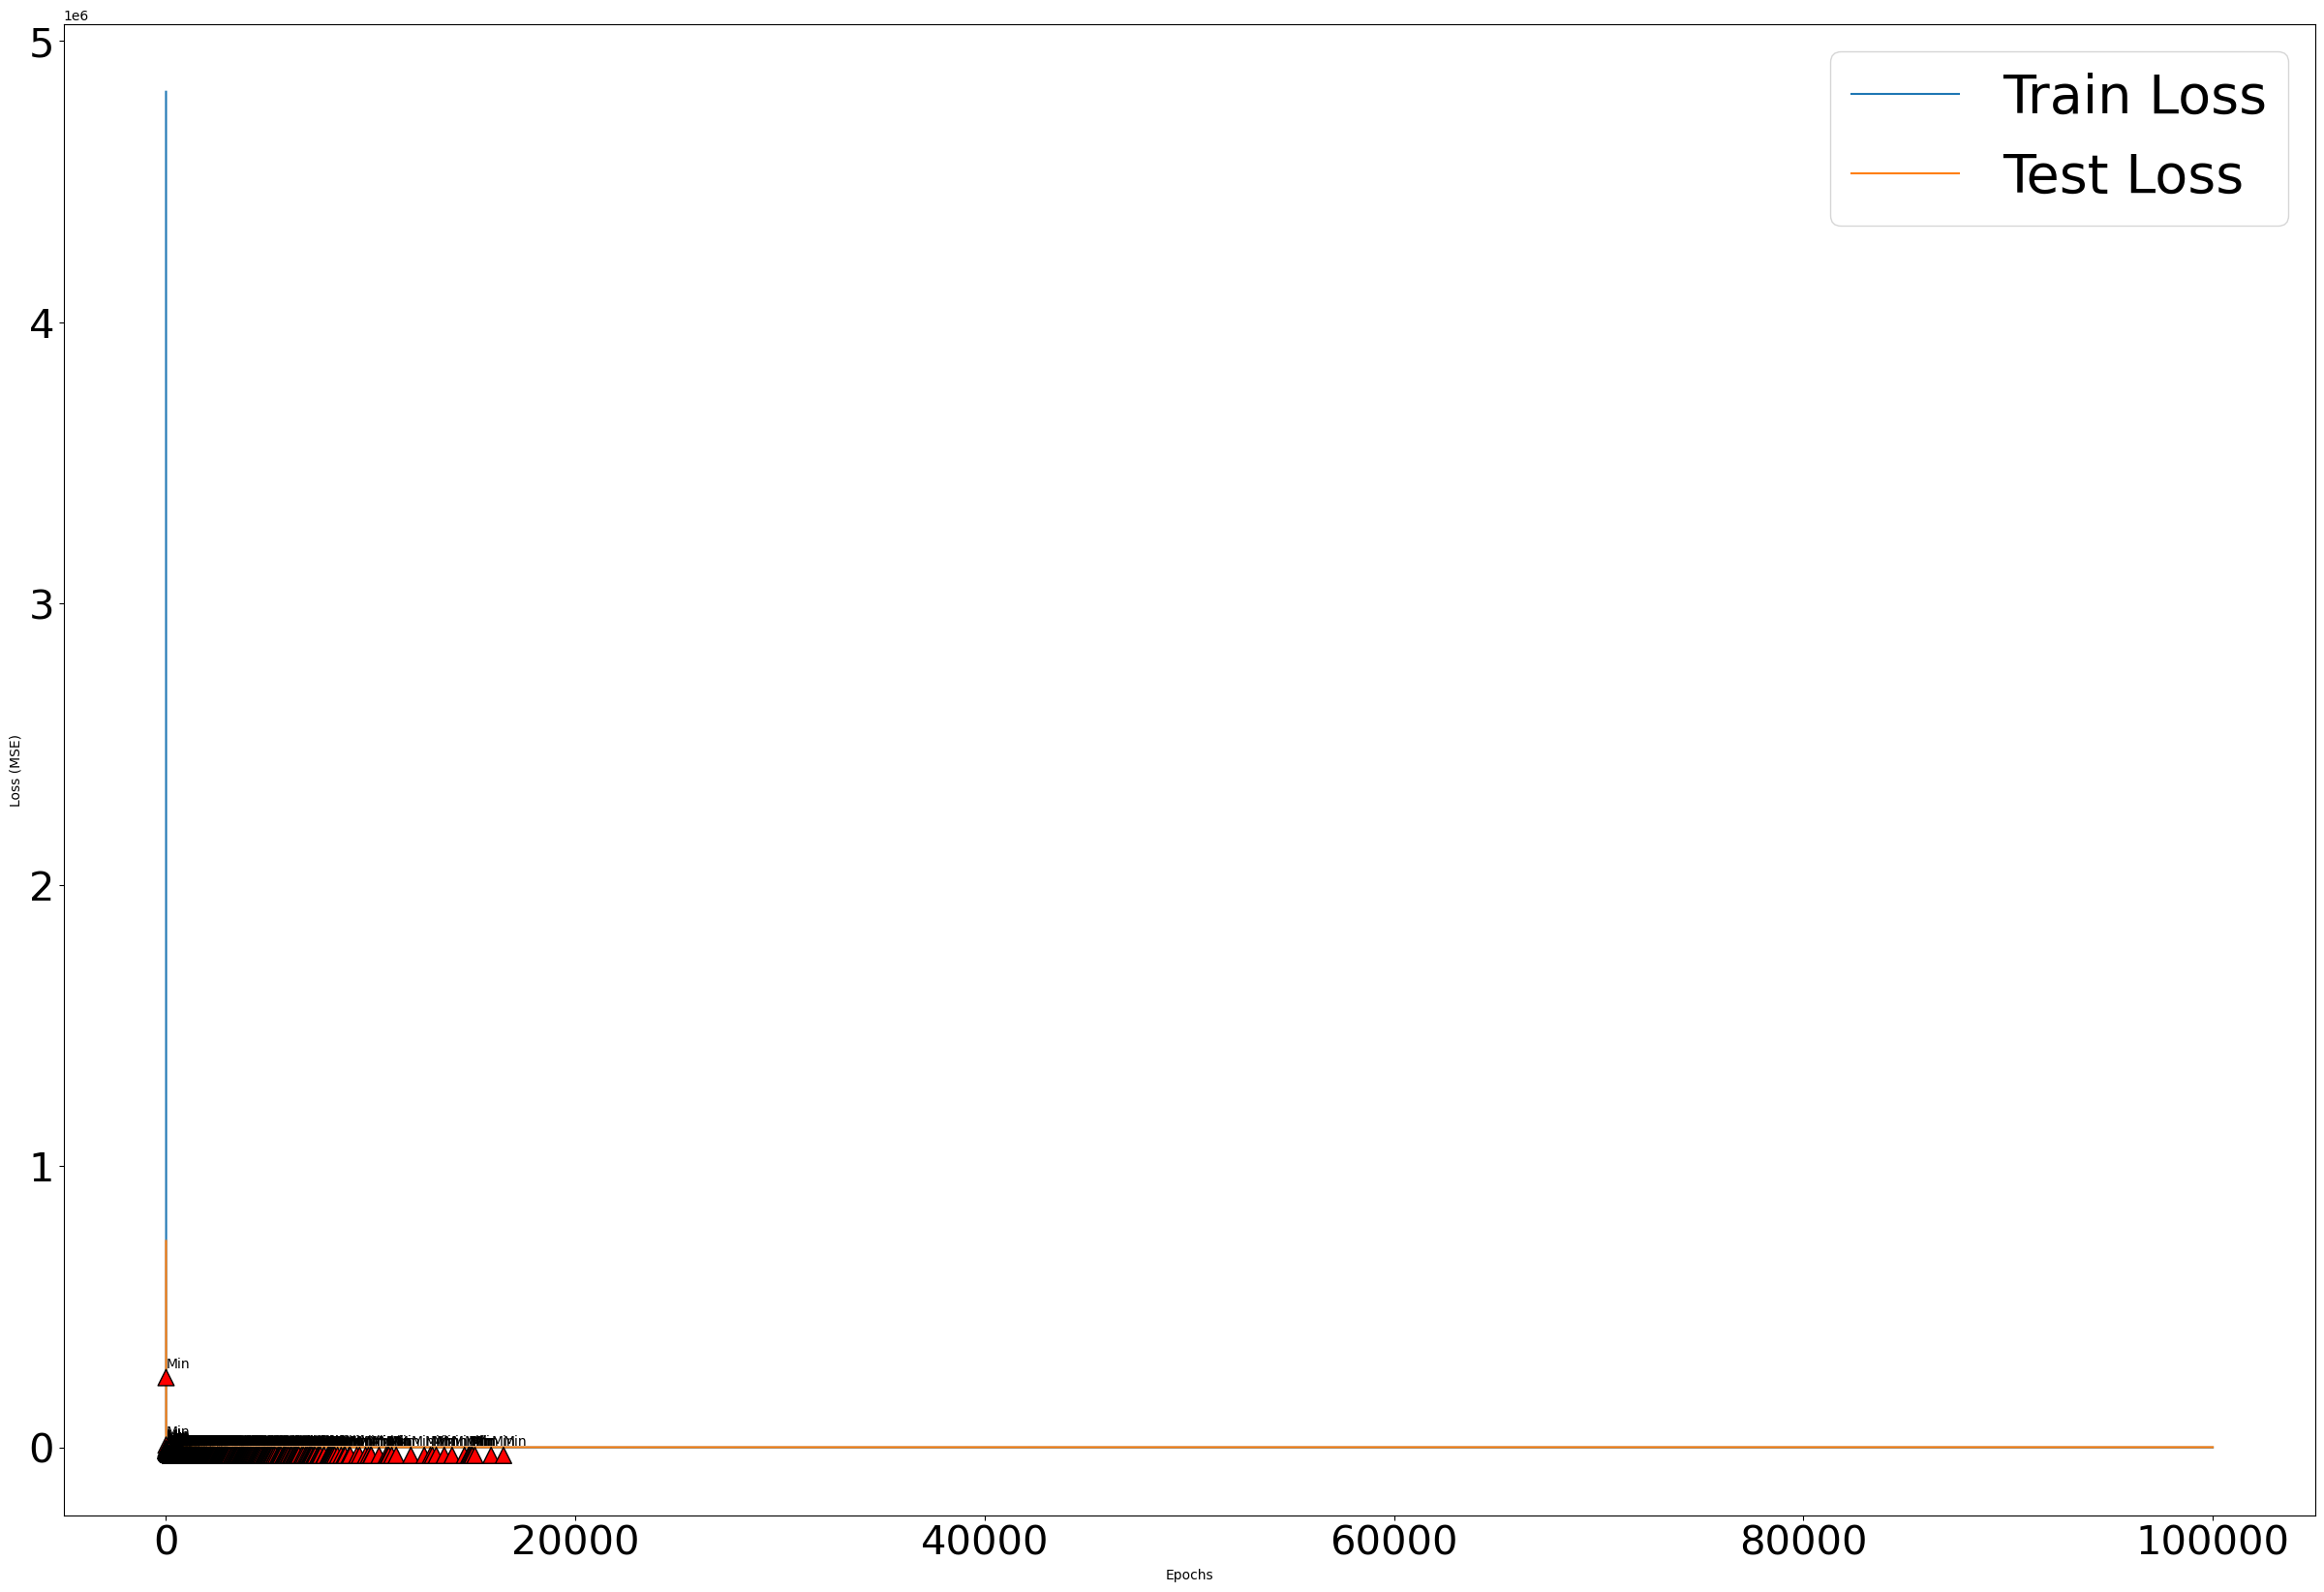

In [13]:

# Plot the data
plt.plot(np.arange(num_epochs)+1, train_losses, label='Train Loss')
plt.plot(np.arange(num_epochs)+1, test_losses, label='Test Loss')

# Track the previous minimum test loss and its index
prev_min_loss = test_losses[0]
prev_min_index = 0

# Annotate each local minimum test loss with arrows
for idx, loss in enumerate(test_losses[1:], start=1):
    if loss < prev_min_loss:
        plt.annotate('Min', xy=(idx+1, loss), xytext=(idx+1, loss + 5000),
                     arrowprops=dict(facecolor='red', shrink=0.05))
        prev_min_loss = loss
        prev_min_index = idx
        
# Add x and y labels
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

# Change axis size
plt.rcParams['axes.labelsize'] = 45  # Change label font size

# Change tick size
plt.tick_params(axis='x', labelsize=30)  # Change tick size for x-axis
plt.tick_params(axis='y', labelsize=30)  # Change tick size for y-axis

# Plot legend, and display figure
plt.legend(fontsize = 40)
plt.show()

In [14]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = NMR_Model_Aq()

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

NMR_Model_Aq(
  (lin1): Linear(in_features=39500, out_features=200, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=200, out_features=8, bias=True)
)

In [15]:
## Switch to directory for saving model metrics

os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/ModelPerformanceMetrics')   

In [16]:
## Test model on testing dataset and deterine RMSE

outputs = model_aq(X_train) # Evaluate input spectra with MLP

# Move tensors to CPU and convert to numpy arrays
outputs_cpu = outputs.detach().cpu().numpy()
y_train_cpu = y_train.detach().cpu().numpy()

err = np.sqrt(mean_squared_error(outputs_cpu, y_train_cpu))  # Determine RMSE
print('model err: ', err)  # Print RMSE

np.save(ModelName + "TrainRMSE",err)

model err:  0.034866553


In [17]:
## Test model on testing dataset and deterine RMSE

model_aq.eval() # Change to evaluation mode (maybe not needed for this model)
outputs = model_aq(X_test) # Evaluate input spectra with MLP

# Move tensors to CPU and convert to numpy arrays
outputs_cpu = outputs.detach().cpu().numpy()
y_test_cpu = y_test.detach().cpu().numpy()

err = np.sqrt(mean_squared_error(outputs_cpu, y_test_cpu))  # Determine RMSE
print('model err: ', err)  # Print RMSE

np.save(ModelName + "TestRMSE",err)

model err:  0.43436542


In [18]:
## Test model on validation dataset and deterine RMSE

model_aq.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model_aq(spectraVal)  # Evaluate input spectra with MLP

# Move tensors to CPU and convert to numpy arrays
outputs_cpu = outputs.detach().cpu().numpy()
concVal_cpu = concVal.detach().cpu().numpy()

err = np.sqrt(mean_squared_error(outputs_cpu, concVal_cpu))  # Determine RMSE
print('model err: ', err)  # Print RMSE

np.save(ModelName + "ValRMSE", err)

model err:  0.3047901


In [19]:
APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ValConc[i]
    Prediction = model_aq(ValSpectra[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)

# Correct the MAPE for the example input with 4 of 8 metabolites present
MAPEs[4] = (APEs[4][0] + APEs[4][1] + APEs[4][4] + APEs[4][6]) / 4

# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))
